# API Tutorial: Full pyInfinityFlow Pipeline

This notebook can be downloaded [here](https://github.com/KyleFerchen/pyInfinityFlow/blob/main/docs/source/notebooks/pyInfinityFlow_API_Tutorial.ipynb).

This tutorial uses the pyInfinityFlow API to carry out the full analysis pipeline with an example dataset. This example is a subset of the previously published mouse lung dataset[[1]](https://www.science.org/doi/10.1126/sciadv.abg0505), the full data set was made publicly available [here](https://flowrepository.org/id/FR-FCM-Z2LP) in flowrepository.org. You can download the subset with the [pyInfinityFlow repository on GitHub](https://github.com/KyleFerchen/pyInfinityFlow), which consists of 10 InfinityMarkers and 5 Isotype controls located in the ['example_dataset'](https://github.com/KyleFerchen/pyInfinityFlow/tree/main/example_data) directory. This directory also contains the relevant InfinityMarker annotation file as well as the Backbone annotation file, which are necessary for the analysis pipeline.

You can download the repository after [Git has been installed](https://git-scm.com/book/en/v2/Getting-Started-Installing-Git) by changing directories to where you want to install it and by using the following command:
```
git clone https://github.com/KyleFerchen/pyInfinityFlow.git
```

## Provide paths for your machine

After you have installed the GitHub repository, you can add the path to the repository below to run this Notebook on your machine:

In [ ]:
# Specify the path to the repository
path_to_repo = "/media/kyle_ssd1/Repositories/pyInfinityFlow/"
# Specify which directory on your machine you want to save the results
my_output_dir = "/media/kyle_ssd1/outputs/"

## Step 1: Preparing the Inputs

### Backbone Annotation File
First, we need to locate the Backbone annotation file. This will instruct the program which channel names in the input FCS files to use as the Backbone (predictors in the regression model). This is simply a .csv or .tsv file with three columns (in the same order as below) to annotate:

1. The channel names in the reference FCS file(s)(the data we use to build the final InfinityFlow object)
2. The channel names in the InfinityMarker FCS files (the data use to fit and validate the models)
3. The final name to use for the channel in the InfinityFlow object

This file should have the column names as the first line.

After downloading the pyInfinityFlow package repository on GitHub, we can access an example file for this test dataset, Eg.:

    '/media/kyle_ssd1/Repositories/pyInfinityFlow/example_data/mouse_lung_dataset_subset_backbone_anno.csv'
    

The ``pyInfinityFlow.InfinityFlow_Utilities`` module provides a simple function (``read_annotation_table``) to read either a .csv, .tsv, or .txt (tab-delimited) file into a pandas.DataFrame object:


In [1]:
import os
from pyInfinityFlow import InfinityFlow_Utilities

# PROVIDE THE PATH TO WHERE YOU DOWNLOADED THE REPOSITORY
path_backbone = os.path.join(path_to_repo, "example_data/mouse_lung_dataset_subset_backbone_anno.csv")
backbone_anno = InfinityFlow_Utilities.read_annotation_table(path_backbone)
backbone_anno

,Reference_Backbone,Query_Backbone,Final_Name
0,FJComp-APC-A,FJComp-APC-A,CD69-CD301b
1,FJComp-AlexaFluor700-A,FJComp-AlexaFluor700-A,MHCII
2,FJComp-BUV395-A,FJComp-BUV395-A,CD4
3,FJComp-BUV737-A,FJComp-BUV737-A,CD44
4,FJComp-BV421-A,FJComp-BV421-A,CD8
5,FJComp-BV510-A,FJComp-BV510-A,CD11c
6,FJComp-BV605-A,FJComp-BV605-A,CD11b
7,FJComp-BV650-A,FJComp-BV650-A,F480
8,FJComp-BV711-A,FJComp-BV711-A,Ly6C
9,FJComp-BV786-A,FJComp-BV786-A,Lineage


### InfinityMarker Annotation File

The InfinityMarker annotation file specifies what FCS files to use to build the regression models and how they should be treated. Each InfinityMarker (Flow Cytometry signal to impute using the backbone) has a row entry in this annotation file for the following columns:
    
1. The FCS file name
2. The InfinityMarker channel name (exactly as it appears in the FCS file)
3. The name to give the channel in the final InfinityFlow object
4. (OPTIONAL) The final name of Isotype InfinityMarker (should be an entry in the third column for the InfinityMarkers that are Isotype controls)

This file is included in the same directory as the Backbone annotation file in the GitHub repository, Eg.:

    '/media/kyle_ssd1/Repositories/pyInfinityFlow/example_data/mouse_lung_dataset_subset_infinity_marker_anno.csv'

Isotype background correction is an optional step in which a linear model is used to regress out the background binding and fluorescence of an antibody raised with a specific immunoglobulin. You can read more about it from the [original publication](https://www.science.org/doi/10.1126/sciadv.abg0505). The InfinityMarker annotation file is used to specify whether or not to perform background correction. This is optional and will only be attempted in the pipeline if this annotation file has a 4th column.

The InfinityMarker annotation file, like the Backbone annotation file, is expected to be either a .csv, .tsv, or .txt (tab-delimited) file, and can also be read into a pandas.DataFrame using the ``read_annotation_table`` function:

In [2]:
path_infmarker = os.path.join(path_to_repo, 
    "example_data/mouse_lung_dataset_subset_infinity_marker_anno.csv")
infinitymarker_anno = InfinityFlow_Utilities.read_annotation_table(path_infmarker)
infinitymarker_anno

,File,Channel,Name,Isotype
0,backbone_Plate2_Specimen_001_G1_G01_073_target...,FJComp-PE(yg)-A,33D1,Isotype_rIgG2b
1,backbone_Plate2_Specimen_001_F7_F07_067_target...,FJComp-PE(yg)-A,Allergin-1,Isotype_mIgG1
2,backbone_Plate2_Specimen_001_F8_F08_068_target...,FJComp-PE(yg)-A,B7-H4,Isotype_AHIgG
3,backbone_Plate1_Specimen_001_A2_A02_002_target...,FJComp-PE(yg)-A,CD1d,Isotype_rIgG2b
4,backbone_Plate1_Specimen_001_G4_G04_076_target...,FJComp-PE(yg)-A,CD103,Isotype_AHIgG
5,backbone_Plate1_Specimen_001_G5_G05_077_target...,FJComp-PE(yg)-A,CD105,Isotype_rIgG2a
6,backbone_Plate1_Specimen_001_G6_G06_078_target...,FJComp-PE(yg)-A,CD106,Isotype_rIgG2a
7,backbone_Plate1_Specimen_001_G7_G07_079_target...,FJComp-PE(yg)-A,CD107a (Lamp-1),Isotype_rIgG2a
8,backbone_Plate1_Specimen_001_G8_G08_080_target...,FJComp-PE(yg)-A,CD107b (Mac-3),Isotype_rIgG1
9,backbone_Plate1_Specimen_001_G9_G09_081_target...,FJComp-PE(yg)-A,CD115,Isotype_rIgG2a


## Step 2: Checking the Inputs and Building an InfinityFlowFileHandler

Next, we need to specify the directory in which the FCS files are saved. This directory is located in the same parent directory as the annotation files on the pyInfinityFlow GitHub repository:

    '/media/kyle_ssd1/Repositories/pyInfinityFlow/example_data/mouse_lung_dataset_subset'

Then we can use the ``check_infinity_flow_annotation_dataframes`` to do the following:

- Validate the input annotation DataFrames
- Scan through the InfinityMarker FCS files to split events into training/validation/pooling subsets
- Return an InfinityFlowFileHandler to store how each of the InfinityMarker files will be processed

Here we will use the n_events_combine parameter to pool events from each of the individual InfinityMarker files for the final InfinityFlow object. Each of original channels from this file will be preserved into the final InfinityFlow object.

Note: it is also possible to use the ``separate_backbone_reference`` argument to supply a separate FCS file onto which the predictions will be made. This is useful if there is a feature(s) that is not well explained by the Backbone channels and therefore should not be imputed.

In [3]:
fcs_dir = os.path.join(path_to_repo, 
    "example_data/mouse_lung_dataset_subset")

file_handler = InfinityFlow_Utilities.check_infinity_flow_annotation_dataframes(\
    backbone_annotation=backbone_anno, 
    infinity_marker_annotation=infinitymarker_anno,
    n_events_train=0, # Use all possible events in the FCS file
    n_events_validate=0, # Use all possible events in the FCS file
    ratio_for_validation=0.5,                                                                            
    n_events_combine=1000, # Events to pool into a final InfinityFlow object
    input_fcs_dir=fcs_dir, 
    verbosity=1)

file_handler

Isotype controls detected. Will attempt to use background correction...


InfinityFlowFileHandler Object from pyInfinityFlow
	.handles the following InfinityMarkers:
			33D1
			Allergin-1
			B7-H4
			CD1d
			CD103
			CD105
			CD106
			CD107a (Lamp-1)
			CD107b (Mac-3)
			CD115
			Isotype_rIgG2b
			Isotype_mIgG1
			Isotype_AHIgG
			Isotype_rIgG2a
			Isotype_rIgG1

	Held in the InfinityFlowFileHandler.handles dictionary

	InfinityFlowFileHandler.list_infinity_markers holds ordered list of InfinityMarkers


For example, you can see how the InfinityMarker "33D1" is stored in the ``file_handler.handles`` dictionary, including the name, file_name, directory, reference_backbone_channels, backbone_channels, prediction_channel, train_indices, test_indices, and pool_indices.

This information will be used later on to carry out XGBoost regression.

In [4]:
file_handler.handles["33D1"]

{'name': '33D1',
 'file_name': 'backbone_Plate2_Specimen_001_G1_G01_073_target_33D1.fcs',
 'directory': '/media/kyle_ssd1/Repositories/pyInfinityFlow/example_data/mouse_lung_dataset_subset',
 'reference_backbone_channels': array(['FJComp-APC-A', 'FJComp-AlexaFluor700-A', 'FJComp-BUV395-A',
        'FJComp-BUV737-A', 'FJComp-BV421-A', 'FJComp-BV510-A',
        'FJComp-BV605-A', 'FJComp-BV650-A', 'FJComp-BV711-A',
        'FJComp-BV786-A', 'FJComp-GFP-A', 'FJComp-PE-Cy7(yg)-A',
        'FJComp-PerCP-Cy5-5-A'], dtype=object),
 'backbone_channels': array(['FJComp-APC-A', 'FJComp-AlexaFluor700-A', 'FJComp-BUV395-A',
        'FJComp-BUV737-A', 'FJComp-BV421-A', 'FJComp-BV510-A',
        'FJComp-BV605-A', 'FJComp-BV650-A', 'FJComp-BV711-A',
        'FJComp-BV786-A', 'FJComp-GFP-A', 'FJComp-PE-Cy7(yg)-A',
        'FJComp-PerCP-Cy5-5-A'], dtype=object),
 'prediction_channel': 'FJComp-PE(yg)-A',
 'train_indices': array([     0,      1,      2, ..., 106341, 106343, 106345]),
 'test_indices': arra

## Step 3: Specify Output Directories

Here, we simply need to specify a directory in which to save the outputs of the pipeline. The ``InfinityFlow_Utilities.setup_output_directories`` function will prepare a dictionary that stores where to save different outputs, and create those directories:

In [5]:
output_paths = InfinityFlow_Utilities.setup_output_directories(\
    output_dir=my_output_dir,
    file_handler=file_handler,
    verbosity=1)

output_paths

{'output_regression_path': '/media/kyle_ssd1/outputs/regression_results',
 'output_umap_feature_plot_path': '/media/kyle_ssd1/outputs/umap_feature_plots',
 'clustering': '/media/kyle_ssd1/outputs/clustering',
 'qc': '/media/kyle_ssd1/outputs/QC',
 'output_umap_bc_feature_plot_path': '/media/kyle_ssd1/outputs/umap_feature_plots_background_corrected'}

## Step 4: Fitting the XGBoost Regression Models

The ``InfinityFlow_Utilities.single_chunk_training`` function is used to create and fit the XGBoost models. It will return a tuple consisting of a ``InfinityFlow_Utilities.CombinedRegressionModels`` object and a dictionary that saves how much time it took to fit the models for the InfinityMarkers.

In [6]:
regression_models, timings_1 = InfinityFlow_Utilities.single_chunk_training(\
    file_handler=file_handler,
    cores_to_use=12,
    use_logicle_scaling=True, 
    normalization_method=None,  
    verbosity=3)

Reading in data from .fcs files for model training...
DEBUG: 		Reading in the data for InfinityMarker 33D1...
DEBUG: 		Reading in the data for InfinityMarker Allergin-1...
DEBUG: 		Reading in the data for InfinityMarker B7-H4...
DEBUG: 		Reading in the data for InfinityMarker CD1d...
DEBUG: 		Reading in the data for InfinityMarker CD103...
DEBUG: 		Reading in the data for InfinityMarker CD105...
DEBUG: 		Reading in the data for InfinityMarker CD106...
DEBUG: 		Reading in the data for InfinityMarker CD107a (Lamp-1)...
DEBUG: 		Reading in the data for InfinityMarker CD107b (Mac-3)...
DEBUG: 		Reading in the data for InfinityMarker CD115...
DEBUG: 		Reading in the data for InfinityMarker Isotype_rIgG2b...
DEBUG: 		Reading in the data for InfinityMarker Isotype_mIgG1...
DEBUG: 		Reading in the data for InfinityMarker Isotype_AHIgG...
DEBUG: 		Reading in the data for InfinityMarker Isotype_rIgG2a...
DEBUG: 		Reading in the data for InfinityMarker Isotype_rIgG1...
Applying Logicle normalizat

In [7]:
regression_models

CombinedRegressionModels Object from pyInfinityFlow
	Contains regression models for the following InfinityMarkers (Response Variables):
33D1,Allergin-1,B7-H4,CD1d,CD103,CD105,CD106,CD107a (Lamp-1),CD107b (Mac-3),CD115,Isotype_rIgG2b,Isotype_mIgG1,Isotype_AHIgG,Isotype_rIgG2a,Isotype_rIgG1

	Uses the following backbone (Explanatory Variables):
FJComp-APC-A,FJComp-AlexaFluor700-A,FJComp-BUV395-A,FJComp-BUV737-A,FJComp-BV421-A,FJComp-BV510-A,FJComp-BV605-A,FJComp-BV650-A,FJComp-BV711-A,FJComp-BV786-A,FJComp-GFP-A,FJComp-PE-Cy7(yg)-A,FJComp-PerCP-Cy5-5-A

The object holds the following variables:
	ordered_training_channels
	var_annotations
	infinity_markers
	regression_models
	parameter_annotations
	infinity_channels
	validation_metrics

	Access regression models as dictionary with the InfinityMarker as the key: 
		Eg. CombinedRegressionModels.regression_models["33D1"]


## Step 5: Validating Regression Models

We can next use held out data from each of the InfinityMarker FCS files to score how well each of the models is able to impute the InfinityMarker expression values with the Backbone features. This is done with the ``InfinityFlow_Utilities.single_chunk_testing`` function. This will return a tuple with an updated ``CombinedRegressionModels`` object that contains validation metrics, and a dictionary to track the timing of the validation.

In [8]:
regression_models, timings_2 = InfinityFlow_Utilities.single_chunk_testing(\
    file_handler = file_handler, 
    regression_models = regression_models,
    use_logicle_scaling=True, 
    normalization_method=None,  
    verbosity=3)

Reading in data from .fcs files for model validation...
DEBUG: 		Reading in the data for InfinityMarker 33D1...
DEBUG: 		Reading in the data for InfinityMarker Allergin-1...
DEBUG: 		Reading in the data for InfinityMarker B7-H4...
DEBUG: 		Reading in the data for InfinityMarker CD1d...
DEBUG: 		Reading in the data for InfinityMarker CD103...
DEBUG: 		Reading in the data for InfinityMarker CD105...
DEBUG: 		Reading in the data for InfinityMarker CD106...
DEBUG: 		Reading in the data for InfinityMarker CD107a (Lamp-1)...
DEBUG: 		Reading in the data for InfinityMarker CD107b (Mac-3)...
DEBUG: 		Reading in the data for InfinityMarker CD115...
DEBUG: 		Reading in the data for InfinityMarker Isotype_rIgG2b...
DEBUG: 		Reading in the data for InfinityMarker Isotype_mIgG1...
DEBUG: 		Reading in the data for InfinityMarker Isotype_AHIgG...
DEBUG: 		Reading in the data for InfinityMarker Isotype_rIgG2a...
DEBUG: 		Reading in the data for InfinityMarker Isotype_rIgG1...
Applying Logicle normaliz

The ``single_chunk_testing`` function will set a dictionary to the ``validation_metrics`` attribute of the ``CombinedRegressionModels`` object. For each InfinityMarker name as a key, a dictionary is stored as the value with the predicted values, ture values, r2_score, and mean_squared_error:

In [9]:
regression_models.validation_metrics

{'33D1': {'pred': array([0.25200623, 0.2564635 , 0.25081083, ..., 0.25893834, 0.23685327,
         0.25687218], dtype=float32),
  'true': array([0.25880677, 0.24245095, 0.25493586, ..., 0.274207  , 0.21523006,
         0.24371576], dtype=float32),
  'r2_score': 0.19209259889025,
  'mean_squared_error': 0.0001764585},
 'Allergin-1': {'pred': array([0.21301892, 0.21872343, 0.20963453, ..., 0.21750394, 0.22308473,
         0.21142632], dtype=float32),
  'true': array([0.26102197, 0.2454918 , 0.24498476, ..., 0.21617137, 0.22679122,
         0.23546468], dtype=float32),
  'r2_score': 0.5829876350462362,
  'mean_squared_error': 0.00061123044},
 'B7-H4': {'pred': array([0.22862323, 0.2501482 , 0.25119272, ..., 0.2621282 , 0.2515326 ,
         0.24431813], dtype=float32),
  'true': array([0.2212211 , 0.22892201, 0.24515927, ..., 0.25912946, 0.23800558,
         0.23579723], dtype=float32),
  'r2_score': 0.17660769306807023,
  'mean_squared_error': 0.00022054944},
 'CD1d': {'pred': array([0.27

## Step 6: Predict InfinityMarker Values for Final InfinityFlow Object

The ``InfinityFlow_Utilities.make_flow_regression_predictions`` function is used to carry out the imputation on the reference FCS dataset to predict the InfinityMarker expression values. This function returns a tuple with the resulting object as an anndata.AnnData object, and a dictionary to store the timing of the prediction steps:

In [10]:
sub_p_adata, timings_3 = InfinityFlow_Utilities.make_flow_regression_predictions(\
    file_handler=file_handler, 
    regression_models=regression_models, 
    use_logicle_scaling=True, 
    normalization_method=None, 
    verbosity=3)

Reading in data from .fcs files for pooling into final InfinityFlow object...
DEBUG: 		Reading in the data for InfinityMarker 33D1...
DEBUG: 		Reading in the data for InfinityMarker Allergin-1...
DEBUG: 		Reading in the data for InfinityMarker B7-H4...
DEBUG: 		Reading in the data for InfinityMarker CD1d...
DEBUG: 		Reading in the data for InfinityMarker CD103...
DEBUG: 		Reading in the data for InfinityMarker CD105...
DEBUG: 		Reading in the data for InfinityMarker CD106...
DEBUG: 		Reading in the data for InfinityMarker CD107a (Lamp-1)...
DEBUG: 		Reading in the data for InfinityMarker CD107b (Mac-3)...
DEBUG: 		Reading in the data for InfinityMarker CD115...
DEBUG: 		Reading in the data for InfinityMarker Isotype_rIgG2b...
DEBUG: 		Reading in the data for InfinityMarker Isotype_mIgG1...
DEBUG: 		Reading in the data for InfinityMarker Isotype_AHIgG...
DEBUG: 		Reading in the data for InfinityMarker Isotype_rIgG2a...
DEBUG: 		Reading in the data for InfinityMarker Isotype_rIgG1...
App

/media/kyle_storage/kyle_ferchen/Python/Env/pyInfinityFlow_dev/lib/python3.8/site-packages/pyInfinityFlow/InfinityFlow_Utilities.py:1469: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  predicted_var.loc[:,"IMPUTED"] = True
/media/kyle_storage/kyle_ferchen/Python/Env/pyInfinityFlow_dev/lib/python3.8/site-packages/pyInfinityFlow/InfinityFlow_Utilities.py:1482: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  var = pd.concat([raw_sub_p_adata.var, predicted_var]),


The resulting AnnData object (``sub_p_adata``) can now be used for downstream analysis steps!

## Step 7: Isotype Background Correction

We can now carry out Isotype background correction using the ``InfinityFlow_Utilities.perform_background_correction`` function, which will return a tuple with 3 values:

1. A pandas.DataFrame of the background corrected data
2. The .var annotation to specify settings for the features
3. Timings dictionary to track how much time was used in the function

In [11]:
background_corrected_data, background_corrected_var, timings_4 = \
    InfinityFlow_Utilities.perform_background_correction(\
        sub_p_adata = sub_p_adata,
        infinity_marker_annotation = infinitymarker_anno, 
        file_handler = file_handler,
        cores_to_use = 12, 
        verbosity = 3)

DEBUG: Feature 33D1 will use isotype Isotype_rIgG2b...
DEBUG: Feature Allergin-1 will use isotype Isotype_mIgG1...
DEBUG: Feature B7-H4 will use isotype Isotype_AHIgG...
DEBUG: Feature CD1d will use isotype Isotype_rIgG2b...
DEBUG: Feature CD103 will use isotype Isotype_AHIgG...
DEBUG: Feature CD105 will use isotype Isotype_rIgG2a...
DEBUG: Feature CD106 will use isotype Isotype_rIgG2a...
DEBUG: Feature CD107a (Lamp-1) will use isotype Isotype_rIgG2a...
DEBUG: Feature CD107b (Mac-3) will use isotype Isotype_rIgG1...
DEBUG: Feature CD115 will use isotype Isotype_rIgG2a...


In [12]:
background_corrected_data.head()

,33D1,Allergin-1,B7-H4,CD1d,CD103,CD105,CD106,CD107a (Lamp-1),CD107b (Mac-3),CD115
0,0.053235,0.083288,0.062567,0.073332,0.050480,0.143983,0.087025,0.060597,0.050773,0.050279
1,0.059184,0.080860,0.043288,0.046708,0.030332,0.049352,0.079781,0.069040,0.047640,0.042443
2,0.059397,0.085905,0.048852,0.151401,0.021355,0.056680,0.089235,0.135968,0.109725,0.052312
3,0.050306,0.078846,0.060089,0.123346,0.041751,0.036221,0.080687,0.058094,0.036672,0.044819
4,0.060201,0.072160,0.055046,0.054883,0.049996,0.056747,0.083932,0.073318,0.054824,0.051910


In [13]:
background_corrected_var.head()

,name,USE_LOGICLE,LOGICLE_T,LOGICLE_W,LOGICLE_M,LOGICLE_A,LOGICLE_APPLIED,IMPUTED
33D1,InfinityMarker_33D1,True,3000000.0,0.0,3.0,1.0,True,True
Allergin-1,InfinityMarker_Allergin-1,True,3000000.0,0.0,3.0,1.0,True,True
B7-H4,InfinityMarker_B7-H4,True,3000000.0,0.0,3.0,1.0,True,True
CD1d,InfinityMarker_CD1d,True,3000000.0,0.0,3.0,1.0,True,True
CD103,InfinityMarker_CD103,True,3000000.0,0.0,3.0,1.0,True,True


## Step 8: Silencing Features

There are some channels that we may want to avoid considering for downstream analyses if they are not relevant to cell state (Eg. The 'Time' parameter). The ``InfinityFlow_Utilities.move_features_to_silent`` function will take the given features_to_silence out of the AnnData.X array, and move them into the AnnData.obsm['silent'] attribute.

For example, we can first list the features present in the InfinityFlow AnnData object:

In [14]:
sub_p_adata.var.index.values

array(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W',
       'FJComp-APC-A', 'FJComp-APC-eFlour780-A', 'FJComp-AlexaFluor700-A',
       'FJComp-BUV395-A', 'FJComp-BUV737-A', 'FJComp-BV421-A',
       'FJComp-BV510-A', 'FJComp-BV605-A', 'FJComp-BV650-A',
       'FJComp-BV711-A', 'FJComp-BV786-A', 'FJComp-GFP-A',
       'FJComp-PE(yg)-A', 'FJComp-PE-Cy7(yg)-A', 'FJComp-PerCP-Cy5-5-A',
       'Time', '33D1', 'Allergin-1', 'B7-H4', 'CD1d', 'CD103', 'CD105',
       'CD106', 'CD107a (Lamp-1)', 'CD107b (Mac-3)', 'CD115',
       'Isotype_rIgG2b', 'Isotype_mIgG1', 'Isotype_AHIgG',
       'Isotype_rIgG2a', 'Isotype_rIgG1'], dtype=object)

Let's move some of the features to silent, so they are not considered for dimensionality reduction or clustering:

In [15]:
features_to_silence = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 
    'FJComp-PE(yg)-A', 'Isotype_rIgG2b', 'Isotype_mIgG1', 'Isotype_AHIgG',
    'Isotype_rIgG2a', 'Isotype_rIgG1', 'Time']

sub_p_adata = InfinityFlow_Utilities.move_features_to_silent(sub_p_adata, features_to_silence)
sub_p_adata

AnnData object with n_obs × n_vars = 15000 × 24
    obs: 'cell_number', 'batch'
    var: 'name', 'USE_LOGICLE', 'LOGICLE_T', 'LOGICLE_W', 'LOGICLE_M', 'LOGICLE_A', 'LOGICLE_APPLIED', 'IMPUTED'
    uns: 'obs_file_origin', 'silent_var'
    obsm: 'silent'

As you can see, the AnnData object now contains an obsm key 'silent' to store the event values for the silenced features, as well as a 'silent_var' pandas.DataFrame in the AnnData.uns attribute.

In [16]:
sub_p_adata.obsm['silent'].head()

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,FJComp-PE(yg)-A,Isotype_rIgG2b,Isotype_mIgG1,Isotype_AHIgG,Isotype_rIgG2a,Isotype_rIgG1,Time
F0:5,44290.410156,48154.0,60277.785156,3829.130127,3626.0,0.590961,0.258807,0.252803,0.247846,0.250860,0.246098,0.256654,0.250912
F0:113,33078.601562,28222.0,76813.804688,9273.810547,7514.0,0.607835,0.245435,0.235438,0.238048,0.257867,0.249520,0.250518,0.251031
F0:137,141369.265625,105760.0,87601.898438,26223.259766,22176.0,0.603203,0.195596,0.230424,0.277973,0.244754,0.227513,0.227703,0.251047
F0:375,86083.023438,62675.0,90012.554688,9570.060547,7683.0,0.608832,0.238332,0.248544,0.235057,0.245086,0.249628,0.247355,0.251229
F0:430,126470.789062,99065.0,83666.179688,7711.190430,6665.0,0.600839,0.213695,0.249908,0.270671,0.260307,0.245320,0.248516,0.251268


In [17]:
sub_p_adata.uns['silent_var'].head()

,name,USE_LOGICLE,LOGICLE_T,LOGICLE_W,LOGICLE_M,LOGICLE_A,LOGICLE_APPLIED,IMPUTED
FSC-A,,False,3000000.0,0.0,3.0,1.0,False,False
FSC-H,,False,3000000.0,0.0,3.0,1.0,False,False
FSC-W,,False,3000000.0,0.0,3.0,1.0,False,False
SSC-A,,False,3000000.0,0.0,3.0,1.0,False,False
SSC-H,,False,3000000.0,0.0,3.0,1.0,False,False


## Step 9: Dimensionality Reduction

Now that the InfinityFlow results are in an AnnData object, we can use the tools provided by Scanpy to perform downstream analysis.

### PCA
If there are a lot of features in the dataset, it may be beneficial to use Principal component analysis to reduce the feature space to a smaller set that captures most of the variation observed.

We can apply the ``scanpy.tl.pca`` function to carry this out on our InfinityFlow AnnData object.
``InfinityFlow_Utilities.make_pca_elbo_plot`` can then be used to generate an elbo plot so we can estimate how few features we can get away with using that capture most of the variation in the dataset:

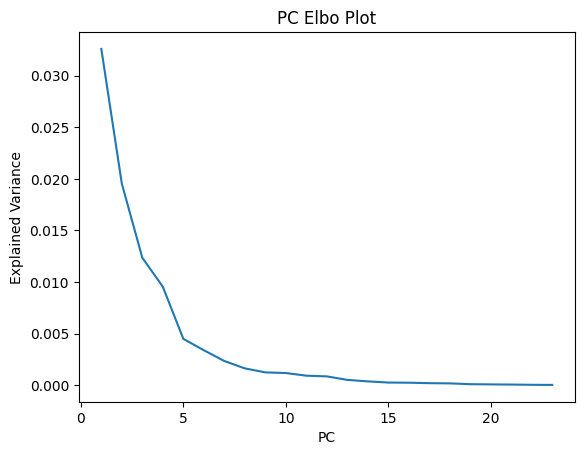

In [18]:
import scanpy as sc
sc.tl.pca(sub_p_adata)
# It is useful to save the features that were used 
# at the time the PCA function was called, as the 
# silenced features may change when the object is
# reloaded.
sub_p_adata.uns['pca_features'] = sub_p_adata.var.index.values

# Make the elbo plot:
InfinityFlow_Utilities.make_pca_elbo_plot(\
    sub_p_adata=sub_p_adata, 
    output_paths=output_paths)

Here, we can see that with the first 15 Principal components, we capture most of the explained variance in the data. So for downstream analysis steps, we will select to use 15 PCs.

Note that the ``make_pca_elbo_plot`` function will save this PC Elbo Plot to the 'QC' directory of the output_dir that we specified in the ``InfinityFlow_Utilities.setup_output_directories`` function. This produced the ``output_paths`` dictionary. We can check to see where the 'QC' folder in the ``output_paths`` on our machine is with the following:

In [19]:
# List the keys available in output_paths
output_paths.keys()

dict_keys(['output_regression_path', 'output_umap_feature_plot_path', 'clustering', 'qc', 'output_umap_bc_feature_plot_path'])

In [20]:
# Print out the 'qc' directory path
output_paths['qc']

'/media/kyle_ssd1/outputs/QC'

### UMAP

UMAP is a very popular method for dimensionality reduction, particularly for the practice of reducing the feature space to 2-Dimensions to view that data as a scatterplot. With this, we can observe the global structure of the data to get an idea of what groups of observations exist. In the context of Flow Cytometry, we can also cluster the data to identify cell types based on surface marker phenotypes.

To carry out UMAP 2D-Dimensionality reduction, we can again use scanpy. First, we need to generate aa estimate of the adjacency matrix, using the ``scanpy.pp.neighbors`` function, which will help the UMAP function optimize where to put the observations in our dataset on the reduced dimension space. We will specify the function to use the first 15 PCs:

In [21]:
sc.pp.neighbors(sub_p_adata, n_pcs=15)
sub_p_adata

AnnData object with n_obs × n_vars = 15000 × 24
    obs: 'cell_number', 'batch'
    var: 'name', 'USE_LOGICLE', 'LOGICLE_T', 'LOGICLE_W', 'LOGICLE_M', 'LOGICLE_A', 'LOGICLE_APPLIED', 'IMPUTED'
    uns: 'obs_file_origin', 'silent_var', 'pca', 'pca_features', 'neighbors'
    obsm: 'silent', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

As you can see, this added the 'neighbors' key to the sub_p_adata.uns attribute, as well as the 'distances' and 'connectivities' to the sub_p_adata.obsp attribute.

We can then call the ``scanpy.tl.umap`` function to generate the low dimensional embedding:

In [22]:
sc.tl.umap(sub_p_adata)
sub_p_adata

AnnData object with n_obs × n_vars = 15000 × 24
    obs: 'cell_number', 'batch'
    var: 'name', 'USE_LOGICLE', 'LOGICLE_T', 'LOGICLE_W', 'LOGICLE_M', 'LOGICLE_A', 'LOGICLE_APPLIED', 'IMPUTED'
    uns: 'obs_file_origin', 'silent_var', 'pca', 'pca_features', 'neighbors', 'umap'
    obsm: 'silent', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We will then move the 2 UMAP vectors to the sub_p_adata.obs DataFrame:

In [23]:
sub_p_adata.obs["umap-x"] = sub_p_adata.obsm['X_umap'][:,0]
sub_p_adata.obs["umap-y"] = sub_p_adata.obsm['X_umap'][:,1]
sub_p_adata.obs.head()

,cell_number,batch,umap-x,umap-y
F0:5,5,33D1,-3.683015,13.849557
F0:113,113,33D1,13.346261,0.064281
F0:137,137,33D1,7.532703,-3.680286
F0:375,375,33D1,9.984137,7.248507
F0:430,430,33D1,12.682547,0.622352


## Step 10: Making Feature Plots

Next, we will make feature plots of each feature currently stored in the ``sub_p_adata.var`` space (not the silenced features). The ``InfinityFlow_Utilities.save_umap_figures_all_features`` function is called on the InfinityFlow AnnData object. Note, we can include the ``background_corrected_data`` to also plot the background corrected features.

This function will save the original prediction feature figures to the 'output_umap_feature_plot_path' and the background corrected feature figures to the 'output_umap_bc_feature_plot_path' in the ``output_paths`` dictionary:

Working on plotting feature 33D1...
Working on plotting feature Allergin-1...
Working on plotting feature B7-H4...
Working on plotting feature CD103...
Working on plotting feature CD105...
Working on plotting feature CD106...
Working on plotting feature CD107a (Lamp-1)...
Working on plotting feature CD107b (Mac-3)...
Working on plotting feature CD115...
Working on plotting feature CD1d...
Working on plotting feature FJComp-APC-A...
Working on plotting feature FJComp-APC-eFlour780-A...
Working on plotting feature FJComp-AlexaFluor700-A...
Working on plotting feature FJComp-BUV395-A...
Working on plotting feature FJComp-BUV737-A...
Working on plotting feature FJComp-BV421-A...
Working on plotting feature FJComp-BV510-A...
Working on plotting feature FJComp-BV605-A...
Working on plotting feature FJComp-BV650-A...
Working on plotting feature FJComp-BV711-A...
Working on plotting feature FJComp-BV786-A...
Working on plotting feature FJComp-GFP-A...
Working on plotting feature FJComp-PE-Cy7(

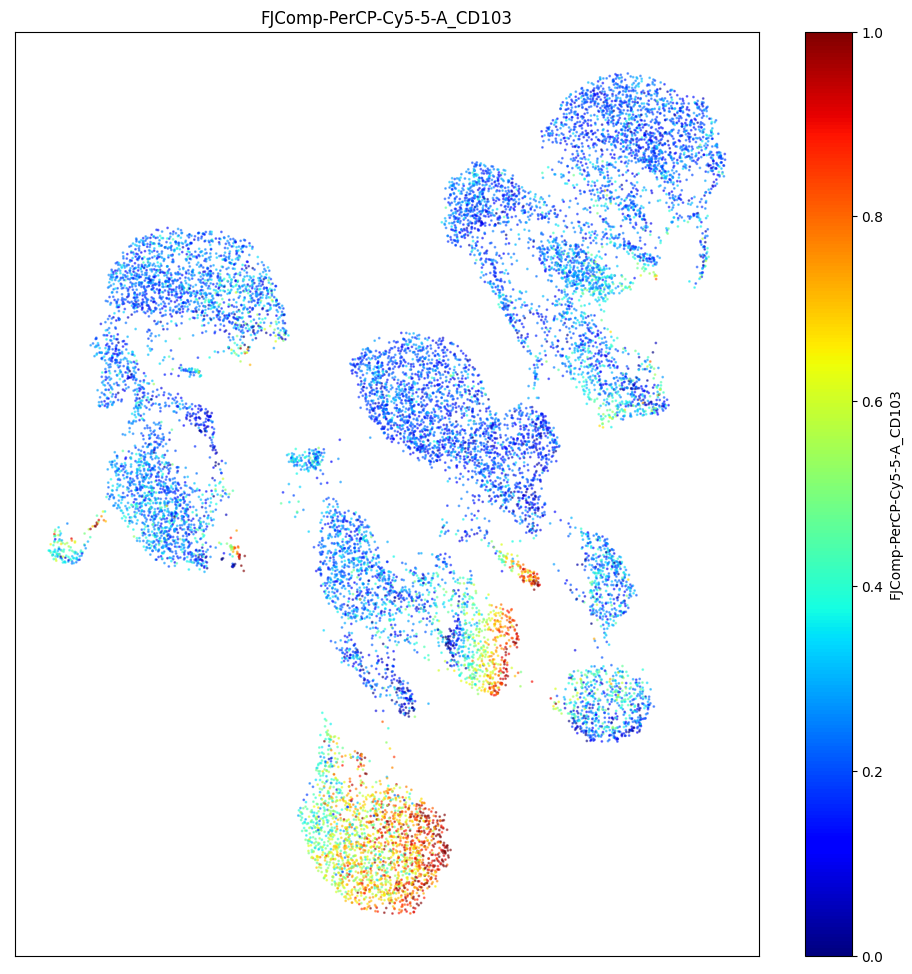

In [24]:
timings_6 = InfinityFlow_Utilities.save_umap_figures_all_features(\
    sub_p_adata, 
    background_corrected_data = background_corrected_data, 
    file_handler = file_handler, 
    output_paths = output_paths, 
    verbosity=3)

## Step 11: Clustering the Data

Next, we can try to cluster the events from our FCS data. The Leiden algorithm is a popular method for clustering data, and is provided in the ``scanpy.tl.leiden`` function. It will utilize the estimated adjacency matrix produced by ``scanpy.pp.neighbors``.

In [25]:
sc.tl.leiden(sub_p_adata)
sub_p_adata

AnnData object with n_obs × n_vars = 15000 × 24
    obs: 'cell_number', 'batch', 'umap-x', 'umap-y', 'leiden'
    var: 'name', 'USE_LOGICLE', 'LOGICLE_T', 'LOGICLE_W', 'LOGICLE_M', 'LOGICLE_A', 'LOGICLE_APPLIED', 'IMPUTED'
    uns: 'obs_file_origin', 'silent_var', 'pca', 'pca_features', 'neighbors', 'umap', 'leiden'
    obsm: 'silent', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

You can see that this function added the 'leiden' feature to our sub_p_adata.obs DataFrame, as well as the 'leiden' key to the sub_p_adata.uns attribute to store the parameters provided to the Leiden clustering algorithm.

### Specify Colors for Clusters

Let's specify a set of colors to use for later plotting the clusters. The ``Plotting_Utilities.assign_rainbow_colors_to_groups`` function provides a quick way to assign colors to a set of cluster assignments:

In [26]:
from pyInfinityFlow.Plotting_Utilities import assign_rainbow_colors_to_groups
groups_to_colors = assign_rainbow_colors_to_groups(\
    sub_p_adata.obs["leiden"].values)

sub_p_adata.uns['groups_to_color'] = groups_to_colors
sub_p_adata.uns['groups_to_color']

{'0': '#8000ff',
 '1': '#6c1fff',
 '10': '#5641fd',
 '11': '#4062fa',
 '12': '#2c7ef7',
 '13': '#169bf2',
 '14': '#00b5eb',
 '15': '#14cae5',
 '16': '#2adddd',
 '17': '#40ecd4',
 '18': '#54f6cb',
 '19': '#6afdc0',
 '2': '#80ffb4',
 '20': '#94fda8',
 '21': '#abf69b',
 '22': '#c0eb8d',
 '23': '#d4dd80',
 '3': '#ebca70',
 '4': '#ffb360',
 '5': '#ff9b52',
 '6': '#ff7e41',
 '7': '#ff5f30',
 '8': '#ff4121',
 '9': '#ff1f10'}

This simply set a hexadecimal color value to each of the 'leiden' clusters and stored the mapping as a dictionary to later use for plotting the clusters.

### Plotting Leiden clusters over UMAP

Now that we have colors associated with our Leiden clusters in the ``sub_p_adata.uns['groups_to_color']`` attribute, we can project those clusters onto the 2D-UMAP to get an idea of where each cluster sits in the reduced dimensional space.

The ``plot_leiden_clusters_over_umap`` function will take in the InfinityFlow AnnData object and the ``output_paths`` dictionary and save this UMAP to the 'clustering' directory in the ``output_dir``:

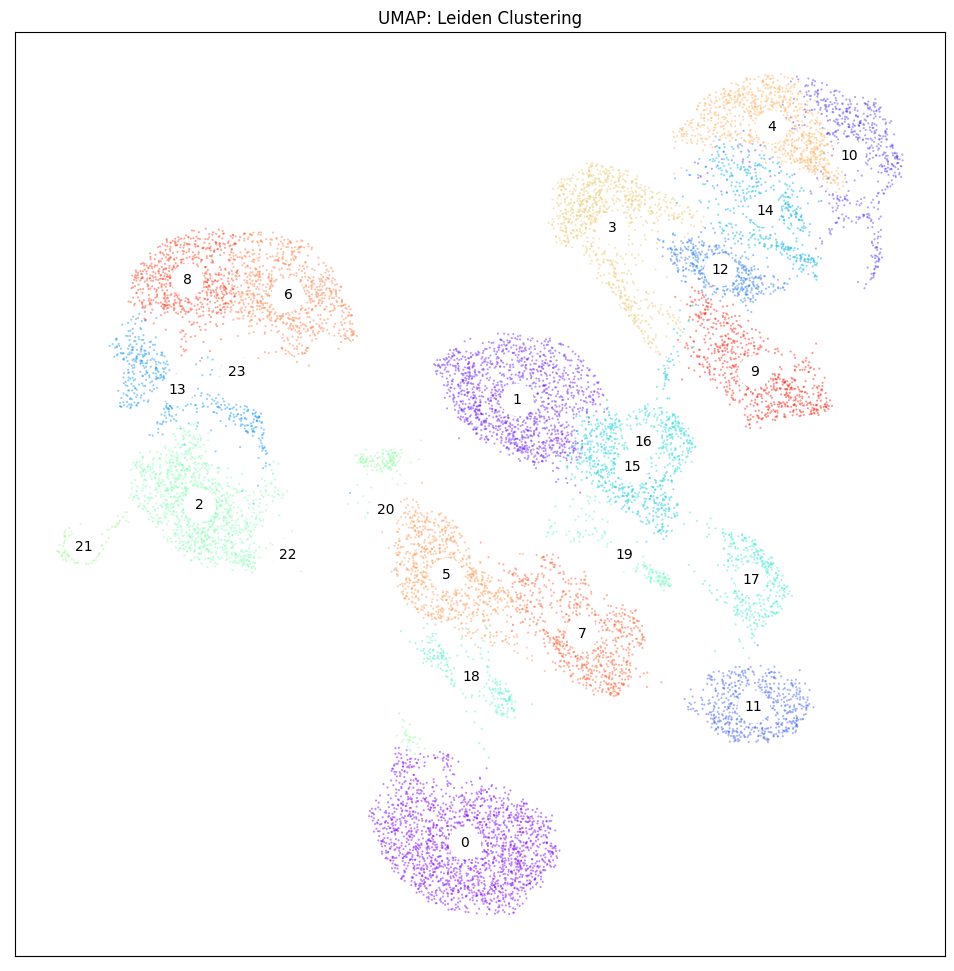

In [27]:
from pyInfinityFlow.Plotting_Utilities import plot_leiden_clusters_over_umap

plot_leiden_clusters_over_umap(\
    sub_p_adata=sub_p_adata, 
    output_dir=os.path.join(output_paths["clustering"], 
        "Leiden_Clusters_over_UMAP.png"), 
    verbosity=3)

In [28]:
# Clustering directory
print(output_paths['clustering'])

/media/kyle_ssd1/outputs/clustering


## Step 12: Find Markers for Clusters

We can use the MarkerFinder algorithm to assign each feature to a cluster which it best uniquely identifies. This is provided as the ``InfinityFlow_Utilities.find_markers_from_anndata`` function, and works directly on the InfinityFlow formatted AnnData object.

Finding markers for Infinity Flow object...
Plotting markers...


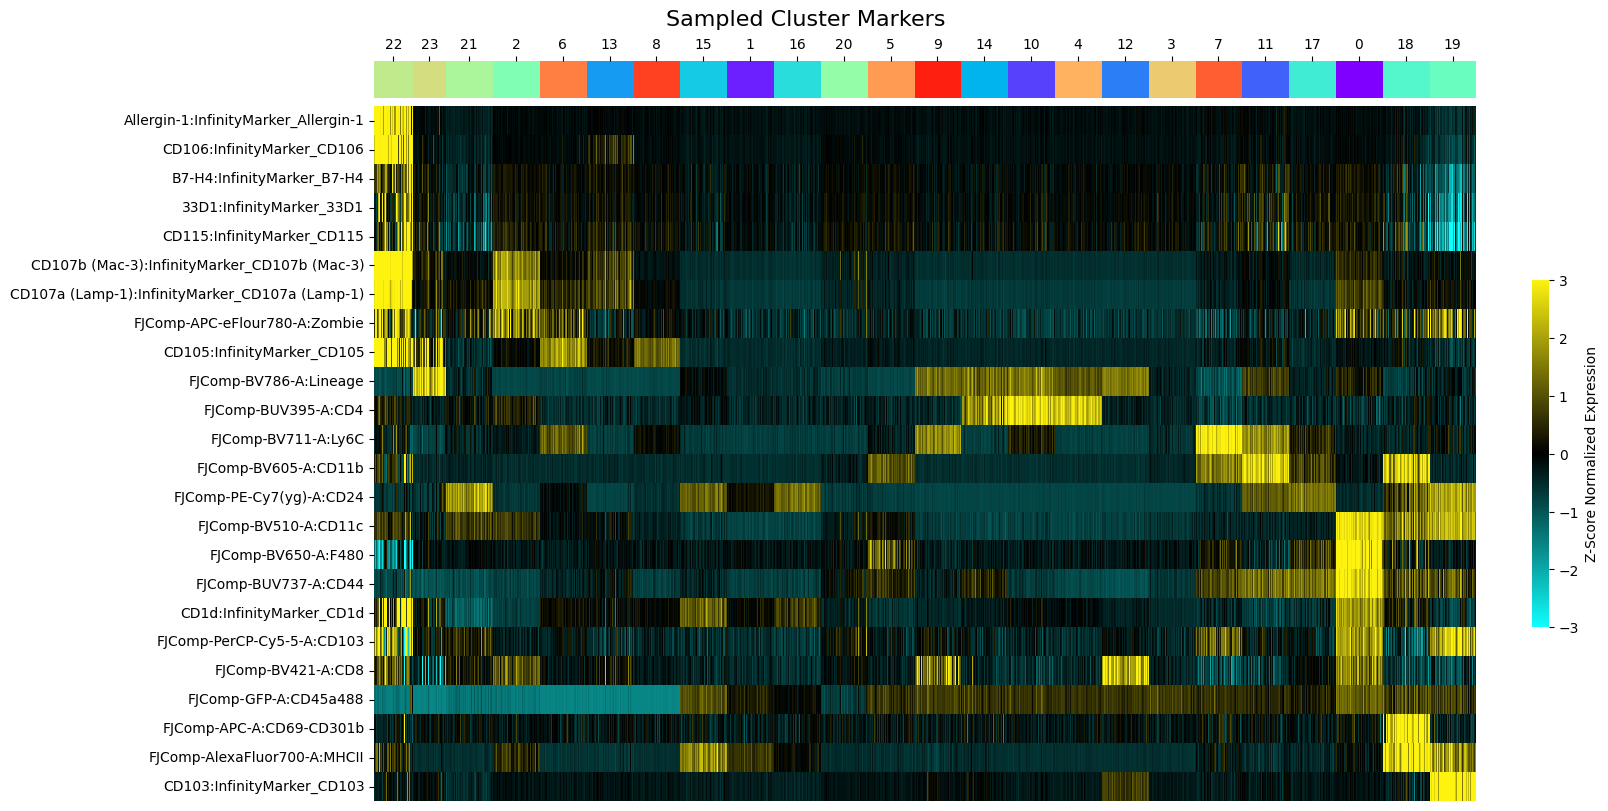

In [29]:
markers_df, cell_assignments = InfinityFlow_Utilities.find_markers_from_anndata(\
    sub_p_adata=sub_p_adata, 
    output_dir=output_paths["clustering"], 
    groups_to_colors=sub_p_adata.uns['groups_to_color'], 
    verbosity=3)

Note, this will save a heatmap of the markers vs. clusters in the ``output_paths['clustering']`` directory, as well as a csv file with the MarkerFinder results:

In [30]:
# Clustering outputs directory
print(output_paths['clustering'])
# Contents of the directory
os.listdir(output_paths['clustering'])

/media/kyle_ssd1/outputs/clustering


['cluster_markers.csv', 'cluster_markers.pdf', 'Leiden_Clusters_over_UMAP.png']

We can also now plot the Leiden clusters over the UMAP plot to get an idea of where each cluster sits in the reduced dimensional space:

## Step 13: Moving Features out of Silent

After we have performed dimensionality reduction and clustering with our features of interest, we may want to move the features that we previously silenced back into the AnnData object. This will make it so when we save our final FCS file, we can include features we may have silenced (Eg. 'Time' or 'FSC-A') that we want to add back.

We can list what features are currently silenced:

In [31]:
sub_p_adata.uns['silent_var'].index.values

array(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W',
       'FJComp-PE(yg)-A', 'Isotype_rIgG2b', 'Isotype_mIgG1',
       'Isotype_AHIgG', 'Isotype_rIgG2a', 'Isotype_rIgG1', 'Time'],
      dtype=object)

Let's move the 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', and 'SSC-W' features out if of the silenced space. The ``InfinityFlow_Utilities.move_features_out_of_silent`` function will take in our AnnData object along with a list of features to move out of silent:

In [32]:
features_to_unsilence = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W']
sub_p_adata = InfinityFlow_Utilities.move_features_out_of_silent(\
    sub_p_adata, 
    features_to_unsilence)

Now these features are back in the AnnData.X and AnnData.var attributes!

In [33]:
sub_p_adata.var

,name,USE_LOGICLE,LOGICLE_T,LOGICLE_W,LOGICLE_M,LOGICLE_A,LOGICLE_APPLIED,IMPUTED
33D1,InfinityMarker_33D1,True,3000000.0,0.0,3.0,1.0,True,True
Allergin-1,InfinityMarker_Allergin-1,True,3000000.0,0.0,3.0,1.0,True,True
B7-H4,InfinityMarker_B7-H4,True,3000000.0,0.0,3.0,1.0,True,True
CD103,InfinityMarker_CD103,True,3000000.0,0.0,3.0,1.0,True,True
CD105,InfinityMarker_CD105,True,3000000.0,0.0,3.0,1.0,True,True
CD106,InfinityMarker_CD106,True,3000000.0,0.0,3.0,1.0,True,True
CD107a (Lamp-1),InfinityMarker_CD107a (Lamp-1),True,3000000.0,0.0,3.0,1.0,True,True
CD107b (Mac-3),InfinityMarker_CD107b (Mac-3),True,3000000.0,0.0,3.0,1.0,True,True
CD115,InfinityMarker_CD115,True,3000000.0,0.0,3.0,1.0,True,True
CD1d,InfinityMarker_CD1d,True,3000000.0,0.0,3.0,1.0,True,True


## Step 14: Saving Regression Outputs

Now that we have our final InfinityFlow object stored in AnnData format, we can save it to storage in different formats for later downstream analyses.

### h5ad File

The h5ad file will preserve the structure of the AnnData object, and let's us quickly load the data for future processing with tools like Scanpy. We can simply use the ``.write`` method on the AnnData object to write the file as an h5ad file.

In [34]:
h5_path = os.path.join(output_paths['output_regression_path'],
    "InfinityFlow_object_logicle_normalized.h5ad")

sub_p_adata.write(h5_path)

The ``output_paths['output_regression_path']`` can provide the traditional path set up with the output_paths directory to save the file.

In [35]:
# Eg. Using the output_paths directory
output_paths['output_regression_path']

'/media/kyle_ssd1/outputs/regression_results'

### Feather File

The Feather file format is commonly used for DataFrame objects. We will lose some of the information present in the AnnData object, but we will be able to very quickly load the DataFrame back into memory:

The ``InfinityFlow_Utilities.anndata_to_df`` function provides a quick way to convert the AnnData object to a DataFrame. We can then reset the index and save the DataFrame as a Feather file with the ``.to_feather`` method provided by Pandas:

In [36]:
# Create an output path for the DataFrame
feather_path = os.path.join(output_paths['output_regression_path'],
    "InfinityFlow_object_logicle_normalized.fea")
# Convert to DataFrame
df = InfinityFlow_Utilities.anndata_to_df(\
    input_anndata=sub_p_adata, 
    use_raw_feature_names=False, 
    add_index_names=True)
# Save as Feather file
df.reset_index().to_feather(feather_path)

df.head()

,33D1:InfinityMarker_33D1,Allergin-1:InfinityMarker_Allergin-1,B7-H4:InfinityMarker_B7-H4,CD103:InfinityMarker_CD103,CD105:InfinityMarker_CD105,CD106:InfinityMarker_CD106,CD107a (Lamp-1):InfinityMarker_CD107a (Lamp-1),CD107b (Mac-3):InfinityMarker_CD107b (Mac-3),CD115:InfinityMarker_CD115,CD1d:InfinityMarker_CD1d,...,FJComp-BV786-A:Lineage,FJComp-GFP-A:CD45a488,FJComp-PE-Cy7(yg)-A:CD24,FJComp-PerCP-Cy5-5-A:CD103,FSC-A:,FSC-H:,FSC-W:,SSC-A:,SSC-H:,SSC-W:
F0:5,0.252006,0.221211,0.254082,0.249303,0.389210,0.249804,0.253386,0.300907,0.253446,0.307087,...,0.235586,0.223836,0.272052,0.276451,44290.410156,48154.0,60277.785156,3829.130127,3626.0,0.590961
F0:113,0.245084,0.211464,0.234267,0.227056,0.261304,0.243082,0.286747,0.282273,0.246122,0.242309,...,0.402271,0.503064,0.489275,0.321054,33078.601562,28222.0,76813.804688,9273.810547,7514.0,0.607835
F0:137,0.241113,0.245277,0.229664,0.220823,0.250333,0.235402,0.419354,0.373128,0.240887,0.404543,...,0.416697,0.678155,0.305735,0.509343,141369.265625,105760.0,87601.898438,26223.259766,22176.0,0.603203
F0:375,0.244557,0.206941,0.245322,0.241661,0.243205,0.244426,0.255690,0.252353,0.249280,0.382239,...,0.296814,0.598728,0.494562,0.217368,86083.023438,62675.0,90012.554688,9570.060547,7683.0,0.608832
F0:430,0.258684,0.223491,0.252599,0.246665,0.267524,0.244834,0.287726,0.294017,0.254916,0.273731,...,0.373348,0.558255,0.484305,0.337422,126470.789062,99065.0,83666.179688,7711.190430,6665.0,0.600839


### FCS File

After converting the InfinityFlow object back into an FCS file, we can then open the file in traditional Flow Cytometry Analysis software tools (Eg. [Flowjo](https://www.flowjo.com/solutions/flowjo)) to perform different custom downstream analyses, like gating to certain populations.


#### Inverting the Logicle Normalization
However, since we used Logicle normalization to more accurately carry out regression and perform dimensionality reduction and clustering, we should invert the Logicle normalization back to the original fluorescence intensity measurements. The pyInfinityFlow format of the AnnData object stores the method for carrying out the Logicle normalization and inverting it in the .var attribute:

In [37]:
sub_p_adata.var.head()

,name,USE_LOGICLE,LOGICLE_T,LOGICLE_W,LOGICLE_M,LOGICLE_A,LOGICLE_APPLIED,IMPUTED
33D1,InfinityMarker_33D1,True,3000000.0,0.0,3.0,1.0,True,True
Allergin-1,InfinityMarker_Allergin-1,True,3000000.0,0.0,3.0,1.0,True,True
B7-H4,InfinityMarker_B7-H4,True,3000000.0,0.0,3.0,1.0,True,True
CD103,InfinityMarker_CD103,True,3000000.0,0.0,3.0,1.0,True,True
CD105,InfinityMarker_CD105,True,3000000.0,0.0,3.0,1.0,True,True


We can invert the Logicle normalization on the features that have the ``USE_LOGICLE`` column set to ``True`` by using the ``InfinityFlow_Utilities.apply_inverse_logicle_to_anndata`` function:

In [38]:
InfinityFlow_Utilities.apply_inverse_logicle_to_anndata(sub_p_adata)
InfinityFlow_Utilities.anndata_to_df(sub_p_adata).head()

,33D1,Allergin-1,B7-H4,CD103,CD105,CD106,CD107a (Lamp-1),CD107b (Mac-3),CD115,CD1d,...,FJComp-BV786-A,FJComp-GFP-A,FJComp-PE-Cy7(yg)-A,FJComp-PerCP-Cy5-5-A,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W
F0:5,110.998680,-1611.187378,225.875824,-38.550339,9981.195312,-10.849790,187.352631,2918.396240,190.660049,3302.118652,...,-799.727173,-1461.367188,1228.294067,1477.697266,44290.410156,48154.0,60277.785156,3829.130127,3626.0,69207.367188
F0:113,-272.058624,-2176.202148,-873.436096,-1278.713989,626.500122,-382.992645,2071.328857,1811.447266,-214.581619,-425.844513,...,11457.474609,30567.076172,26846.810547,4209.315430,33078.601562,28222.0,76813.804688,9273.810547,7514.0,80884.835938
F0:137,-492.217468,-261.397980,-1131.551514,-1633.387573,18.449854,-810.031494,13642.258789,8355.895508,-504.758484,11730.511719,...,13281.506836,154731.609375,3217.331787,32420.519531,141369.265625,105760.0,87601.898438,26223.259766,22176.0,77496.765625
F0:375,-301.269897,-2443.946289,-258.863922,-461.783051,-376.178040,-308.487518,314.955200,130.189346,-39.852901,9252.339844,...,2669.240967,74358.414062,28219.044922,-1832.219971,86083.023438,62675.0,90012.554688,9570.060547,7683.0,81632.640625
F0:430,480.960388,-1480.978882,143.819992,-184.526932,973.659363,-285.889282,2128.691162,2501.141357,272.047882,1323.218140,...,8376.817383,51127.210938,25615.402344,5362.881836,126470.789062,99065.0,83666.179688,7711.190430,6665.0,75823.031250


You can see that the fluorescence derived values are now no longer between 0 and 1, indicating that the Logicle normalization has been inverted.

We can then save the data as an FCS file with the ``InfinityFlow_Utilities.save_fcs_flow_anndata`` function:

In [39]:
InfinityFlow_Utilities.save_fcs_flow_anndata(\
    sub_p_adata = sub_p_adata, 
    background_corrected_data = background_corrected_data, 
    background_corrected_var = background_corrected_var, 
    file_handler = file_handler, 
    output_paths = output_paths, 
    add_umap = True,
    use_logicle = True, 
    verbosity=3)

Writing out base prediction values to fcs file...
WARNING! No features required inverting logicle normalization at this time.
Omitting spillover matrix...
WARNING! TEXT segment value for key $P25S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P26S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P27S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P28S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P29S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P30S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P31S is empty. Excluding from written file.
WARNING! TEXT segment value for key $P32S is empty. Excluding from written file.
Writing out background-corrected prediction values to fcs file...
Omitting spillover matrix...
WARNING! TEXT segment value for key $P25S is empty. Excluding from written file.
WARNING! TEXT segment

{'file_export': 2.1501059532165527}

## Finish

We have now carried out all of the steps of the analysis pipeline provided by pyInfinityFlow, using the API!